In [1]:
from mtcnn.mtcnn import MTCNN
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import load_model
%matplotlib inline

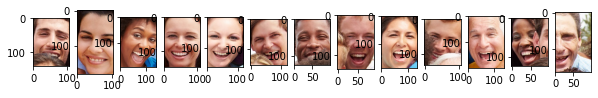

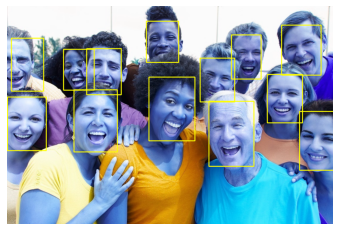

In [2]:
# Loading images 
img = cv2.imread("sample.jpeg")
img_cpy = img.copy()
# Convert the image to RGB, 
# In case the image has an alpha channel or is black and white.
img_rgb = cv2.cvtColor(img_cpy, cv2.COLOR_BGR2RGB)

# Multi-Task Cascaded Convolutional Neural Network, or MTCNN,
# for face detection - finding and extracting faces from photos.
detector = MTCNN()
result = detector.detect_faces(np.asarray(img_rgb))
f, ax = plt.subplots(1,len(result),figsize=(10,10))
for i, face in enumerate(result):
    # pixel coordinates of the bounding box
    x1,y1,width,height = face['box']
    # Sometimes it returns negative coordinates
    x1, y1 = abs(x1), abs(y1)
    # x2, y2 are opposite coordinates
    x2 = x1 + width
    y2 = y1 + height
    # Deriving pixels for face only
    face_px = img_rgb[y1:y2, x1:x2]
    ax[i].imshow(face_px)
    # Draw rectangle over the faces
    cv2.rectangle(img_cpy, (x1, y1), (x2, y2), (255, 255, 0),2)

plt.show()
plt.axis('off')
plt.imshow(img_cpy)
plt.show()


In [3]:
detector = MTCNN()
def extractFace(file):
    # Loading images 
#     print(file)

    img = cv2.imread(file)
    if img is None:
        return None
    img_cpy = img.copy()
    # Convert the image to RGB, 
    # In case the image has an alpha channel or is black and white.
    img_rgb = cv2.cvtColor(img_cpy, cv2.COLOR_BGR2RGB)
    result = detector.detect_faces(img_rgb)
    # Assuming one face per image during training
    face = result[0]
    x1,y1,width,height = face['box']
    # Sometimes it returns negative coordinates
    x1, y1 = abs(x1), abs(y1)
    # x2, y2 are opposite coordinates
    x2 = x1 + width
    y2 = y1 + height
    # Deriving pixels for face only
    face_px = img_rgb[y1:y2, x1:x2]
    # Resizing the face image to 160px 160px to be consumed by facenet
    face_px = cv2.resize(face_px, (160,160))
    return face_px

In [4]:
def getFacesFromDir(directory):
    faces = []
    for file in os.listdir(directory):
        path = f'{directory}/{file}'
        face = extractFace(path)
        if face is not None:
            faces.append(face)
    return faces;

In [5]:
def load_dataset(dir_path):
    X=[]
    y=[]
    for subdir in os.listdir(dir_path):
    # Path of sub directory to read images
        path = f'{dir_path}/{subdir}'
        if not os.path.isdir(path):
            continue
        faces = getFacesFromDir(path)
        labels = [subdir] * len(faces)
        print(f'Loaded {len(faces)} pics of {subdir}')
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [9]:
train_dir = "data/train"
X_train,y_train = load_dataset(train_dir)

Loaded 14 pics of ben_afflek
Loaded 19 pics of madonna
Loaded 17 pics of elton_john
Loaded 22 pics of mindy_kaling
Loaded 21 pics of jerry_seinfeld


In [10]:
test_dir = "data/val"
X_test,y_test = load_dataset(test_dir)

Loaded 5 pics of ben_afflek
Loaded 5 pics of madonna
Loaded 5 pics of elton_john
Loaded 5 pics of mindy_kaling
Loaded 5 pics of jerry_seinfeld


In [6]:
model = load_model('facenet_keras.h5')
# Model takes (160,160,3 )input dims
# Model expects standardized pixel inout
print(model.inputs)
# And outputs 128 dim vector for each image
print(model.outputs)

[<tf.Tensor 'input_1_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


In [11]:
mean =X_train.mean(axis=(0,1,2))
std = X_train.std(axis=(0,1,2))

In [12]:
def getImageEmbeddings(x):
    # Standardise pixel values across all channels
    x = (x - mean)/std
    # Convert each image to 128 vector
    pred = model.predict(x)
    return pred

In [13]:
X_train_emb = getImageEmbeddings(X_train)

In [14]:
X_test_emb =getImageEmbeddings(X_test)

In [15]:
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.svm import SVC

In [16]:
# Normalise embeddings  - Scaling so that the magnitude of vector is 1
# We use l2 normalisation
nm = Normalizer(norm="l2")
Xtrain = nm.transform(X_train_emb)
Xtest= nm.transform(X_test_emb)

In [17]:
# Encode labels for tarining
le = LabelEncoder().fit(y_train)
ytrain = le.transform(y_train)
ytest = le.transform(y_test)

In [19]:
le.classes_

array(['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna',
       'mindy_kaling'], dtype='<U14')

In [20]:
# We use Linear Support Vector (SVM) for normalised image embeddings
class_model = SVC(kernel='linear', probability=True)
class_model.fit(Xtrain, ytrain)

SVC(kernel='linear', probability=True)

In [21]:
train_pred = class_model.predict(Xtrain)

In [28]:
test_pred = class_model.predict(Xtest)

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(ytrain, train_pred)

1.0

In [33]:
accuracy_score(ytest, test_pred)

1.0

In [34]:
import pickle
with open('models/svc_model.pkl', 'wb') as fid:
    pickle.dump(class_model, fid)    


In [35]:
params ={'mean':mean, 'std': std, 'classes':le.classes_}
with open('models/params.pkl', 'wb') as fid:
    pickle.dump(params, fid)    


In [36]:
with open('models/params.pkl', 'rb') as fid:
    image_params = pickle.load(fid)
with open('models/svc_model.pkl', 'rb') as fid:
    svc_model = pickle.load(fid)

In [37]:
image_params

{'mean': array([167.43719548, 125.26521967, 105.06035408]),
 'std': array([66.03227012, 58.80778222, 57.42097136]),
 'classes': array(['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna',
        'mindy_kaling'], dtype='<U14')}

In [38]:
detector = MTCNN()
def extractFaces(file):
    # Loading images 
    img = cv2.imread(file)
    img_cpy = img.copy()
    # Convert the image to RGB, 
    # In case the image has an alpha channel or is black and white.
    img_rgb = cv2.cvtColor(img_cpy, cv2.COLOR_BGR2RGB)
    result = detector.detect_faces(img_rgb)
    face_imgs = []
    for face in result:
        x1,y1,width,height = face['box']
        # Sometimes it returns negative coordinates
        x1, y1 = abs(x1), abs(y1)
        # x2, y2 are opposite coordinates
        x2 = x1 + width
        y2 = y1 + height
        face_px = img_rgb[y1:y2, x1:x2]
        # Resizing the face image to 160px 160px to be consumed by facenet
        face_px = cv2.resize(face_px, (160,160))
        face_imgs.append(face_px)
    return np.asarray(face_imgs)

model = load_model('facenet_keras.h5')
mean = image_params['mean']
std = image_params['std']
classes = image_params['classes']
def getImageEmbeddings(x):
    # Standardise pixel values across all channels
    x = (x - mean)/std
    # Convert each image to 128 vector
    pred = model.predict(x)
    return pred

nm = Normalizer(norm="l2")
def normaliseEmbeddings(x):
    # Normalise embeddings
    return nm.transform(x)

In [53]:
def recognizeSingleImage(file_name):
    faces_px = extractFaces(file_name)
    X = getImageEmbeddings(faces_px)
    X = normaliseEmbeddings(X)
    pred_label = svc_model.predict(X)
    pred_prob =np.amax(svc_model.predict_proba(X) ,axis=1)
#     img = cv2.imread(file_name)
    for i ,prob in  enumerate(pred_prob):
        if(prob > 0.56):
            print('prob',prob,i)
            plt.imshow(faces_px[i])
            plt.show()
            print(classes[pred_label[i]])   

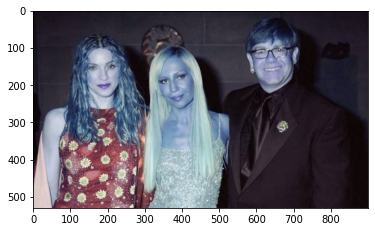

prob 0.8850593571637319 0


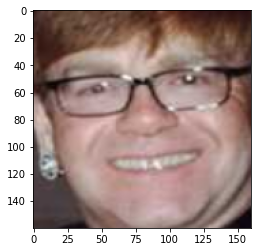

elton_john
prob 0.8623315052902416 2


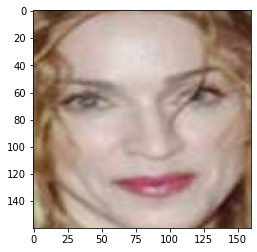

madonna


In [55]:
img = cv2.imread("em.jpeg")
img_cpy = img.copy()
plt.imshow(img_cpy)
plt.show()
recognizeSingleImage("em.jpeg")

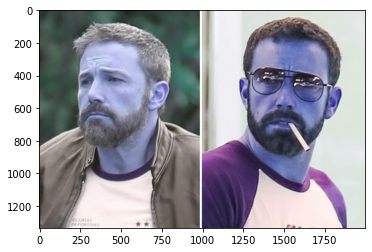

prob 0.9031806925925071 0


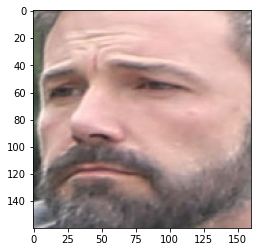

ben_afflek
prob 0.6162353734237714 1


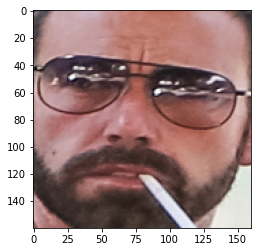

ben_afflek


In [56]:
img = cv2.imread("ba.jpg")
img_cpy = img.copy()
plt.imshow(img_cpy)
plt.show()
recognizeSingleImage("ba.jpg")